<a href="https://colab.research.google.com/github/martamsimoes10/MPA/blob/main/Decomp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MADSAD@CBS|ISCAC-IPC**

**Métodos de Previsão Aplicados**

**jleite@iscac.pt**

**DECOMPOSIÇÃO DE SÉRIES TEMPORAIS**


# Preâmbulo

In [ ]:
options(repr.plot.width=15, repr.plot.height=6)

In [ ]:
install.packages('gridExtra') #para organizar os gráficos

In [ ]:
install.packages('fpp3')

In [ ]:
library(fpp3)

In [ ]:
install.packages('seasonal')

In [ ]:
library(seasonal)

# Importação dos dados

In [ ]:
#uma serie temporal e univariada.
#só estamos a ver as vendas a retalho para 1 unidade estatistica
tsm <- readxl::read_excel('4-Decomp-dados.xlsx', sheet = 'Mult', range = 'A2:B159')
#:: ativar um pacote para uma utilização
ts1 <- tsibble(Data = yearmonth(tsm$AnoMes), Obs = tsm$Trans, index = Data)
#por defeito vai importar uma tibble mas como são series temporais tem de ser tsibble
#a variavel indice é a que indica data. para ser uma tsibble temos de ter obrigatoriamente o parametro index
#a variavel key neste caso não é preciso porque só temos uma unidade estatistica, só precisamos de key quando tempo varias unidades estatisticas
#cria uma tabela com dados temporais em que a primeira coluna é Data - o que vamos ter é o ano e o mes que vamos buscar à tabela x
#cria outra coluna com as observações que se chama obs - o que tem a coluna? tem os valores que vai buscar às transações
print(ts1)

In [ ]:
tsa <- readxl::read_excel('4-Decomp-dados.xlsx', sheet = 'Adit', range = 'A12:B300')
tsa2 <- tsibble(Data = yearmonth(tsa$YM), Obs = tsa$Rsales, index = Data)
ts2 <- tsa2 %>%
          filter( year(Data) >= 2005)
#filtrar linhas que os anos sejam superiores a 2005
print(ts2)

In [ ]:
library(readr)

In [ ]:
tsCOVID <- read_csv('data.csv', col_types = cols(data = col_date(format = '%d-%m-%Y')))
#readr - para ler csv
# se não especificarmos a data nao vem de forma correta, então precisamos das ultimas especificações: definir o tipo de colunas
#data - é mesmo o nome a coluna
#col_date - função
#e especificar o formato: Y(maiusculo) - 4 digitos
ts3 <- tsCOVID %>% 
  as_tsibble(index = data) %>% #converter em tsibble, fixa indice para tornar tabela temporal
    select(data, confirmados) %>% #selecionar colunas
      mutate(confirmados_dia = confirmados - lag(confirmados)) %>% #criar uma coluna dos confirmados dia (valor de um dia menos o anterior - lag de ordem 1)
        filter(data > '2020-02-26') #só mostrar quando a data é superior a 26 de fevereiro porque não iriamos ter valor nessa linha
        #datas funciona como strings
print(ts3)

# Cronogramas das séries temporais

In [ ]:
autoplot(ts1, Obs) +
  labs(title = 'Saldo das transações relacionadas com viagens e turismo - Portugal',
       subtitle = 'Dados mensais entre janeiro de 2002 e janeiro de 2015',
       caption = 'Fonte: Banco de Portugal | BdP (http://www.bportugal.pt/Mobile/BPStat)') +
  xlab('') + ylab('milhões de EUR') +
  scale_x_yearmonth(date_breaks = '1 year', date_labels = '%B %Y') #B - meses sem abreviatura/ Y - anos com 4 digitos

#package ggplot2

In [ ]:
autoplot(ts2, Obs) +
  labs(title = 'Vendas a retalho - Estados Unidos da América',
       subtitle = 'Dados mensais entre janeiro de 2005 e dezembro de 2015',
       caption = 'Fonte: Federal Reserve Economic Data | FRED (https://fred.stlouisfed.org/)') +
  xlab('') + ylab('milhões de USD') +
  scale_x_yearmonth(date_breaks = '1 year', date_labels = '%b %y') #b - meses como abreviatura/ y - anos com 2 digitos

In [ ]:
autoplot(ts3, confirmados_dia) +
  labs(title = 'Casos Novos COVID-19 em Portugal',
       subtitle = 'Número diário de novos casos entre 27/02/2020 e 31/05/2021',
       caption = 'Fonte: covid19pt-data em https://github.com/dssg-pt/covid19pt-data (01/06/2021)',
       x = '', y = '')

# Média móvel simples para `ts3`

In [ ]:
ts3 <- ts3 %>%
    mutate(MA7_left = slider::slide_dbl(confirmados_dia, mean, .before = 6, .after = 0, .complete = TRUE),
           MA7_center = slider::slide_dbl(confirmados_dia, mean, .before = 3, .after = 3, .complete = TRUE),
           MA7_right = slider::slide_dbl(confirmados_dia, mean, .before = 0, .after = 6, .complete = TRUE)) #criar novas colunas

print(head(ts3, n=10))
print(tail(ts3, n=10))

In [ ]:
autoplot(ts3, confirmados_dia, color = 'gray') + 
  autolayer(ts3, MA7_center, color = 'red3') + #juntar camada por cima do gráfico
  labs(title = 'Casos Novos COVID-19 em Portugal',
       subtitle = 'Número diário de novos casos (cinzento) entre 27/02/2020 e 31/05/2021 e respetiva média móvel a 7 dias (vermelho)',
       caption = 'Fonte: covid19pt-data em https://github.com/dssg-pt/covid19pt-data (01/06/2021)',
       x = '', y = '')

# Média móvel dupla para `ts1`

In [ ]:
ts1_ma <- ts1 %>% #copiar antiga e criar novas colunas
    mutate(MA12_l = slider::slide_dbl(Obs, mean, .before = 6, .after = 5, .complete = TRUE), #centrada ligeiramente à esquerda
           MA12_r = slider::slide_dbl(Obs, mean, .before = 5, .after = 6, .complete = TRUE),#centrada ligeiramente à direita
           double_MA12 = (MA12_l + MA12_r)/2) #média das médias móveis
print(head(ts1_ma, n=10))

# A tsibble: 10 x 5 [1M]
       Data   Obs MA12_l MA12_r double_MA12
      <mth> <dbl>  <dbl>  <dbl>       <dbl>
 1 2002 Jan  176.    NA     NA          NA 
 2 2002 Feb  171.    NA     NA          NA 
 3 2002 Mar  240.    NA     NA          NA 
 4 2002 Apr  261.    NA     NA          NA 
 5 2002 May  328.    NA     NA          NA 
 6 2002 Jun  316.    NA    321.         NA 
 7 2002 Jul  519.   321.   319.        320.
 8 2002 Aug  605.   319.   319.        319.
 9 2002 Sep  416.   319.   317.        318.
10 2002 Oct  360.   317.   319.        318.


In [ ]:
autoplot(ts1_ma, Obs, color = 'gray') + 
  autolayer(ts1_ma, double_MA12, color = 'red3') + #outra alternativa para adicionar camada (geom_line)
  labs(title = 'Saldo das transações relacionadas com viagens e turismo - Portugal',
       subtitle = 'Dados mensais entre janeiro de 2002 e janeiro de 2015 (cinzento) e respetiva média móvel dupla a 12 meses (vermelho)',
       caption = 'Fonte: Banco de Portugal | BdP (http://www.bportugal.pt/Mobile/BPStat)') +
  xlab('') + ylab('milhões de EUR') +
  scale_x_yearmonth(date_breaks = '1 year', date_labels = '%b %y')

In [ ]:
#acrescentar coluna com a componente irregular (Rt)
#aditivo: Yt = Tt + Rt <=> Rt = Yt - Tt
#multiplicativo: Yt = Tt * Rt <=> Rr = Yt / Tt
ts1_ma <- ts1_ma %>%
        mutate(comp_irregular = Obs / double_MA12)
        
print(ts1_ma)

In [ ]:
ts3 <- ts3 %>%
      mutate(comp_irregular = confirmados_dia - MA7_center) 
      
head(ts3)

In [ ]:
autoplot(ts3, comp_irregular)

# Decomposição clássica para `ts1`

In [ ]:
comp_ts1_DC_adit <- ts1 %>% #componente da serie s1 da decomposiçao classica aditivo
    model(classical_decomposition(Obs, "additive")) %>% 
    components()

print(comp_ts1_DC_adit)

In [ ]:
comp_ts1_DC_mult <- ts1 %>%  #componente da serie s1 da decomposiçao classica multiplicativa
    model(classical_decomposition(Obs, "multiplicative")) %>% 
    components()

print(comp_ts1_DC_mult)
#random - irregular

In [ ]:
ts1_DC_adit_plot <- autoplot(comp_ts1_DC_adit) + #faz a decomposição de todas as colunas que existem nesta tabela
  scale_x_yearmonth(date_breaks = '3 years', date_labels = '%b/%Y')

ts1_DC_mult_plot <- autoplot(comp_ts1_DC_mult) +
  scale_x_yearmonth(date_breaks = '3 years', date_labels = '%b/%Y') #mudar a escala para de 3 em 3 anos

#comparar a aditiva com a multiplicativa

gridExtra::grid.arrange(ts1_DC_adit_plot, ts1_DC_mult_plot, ncol=2) #colocar os gráficos lado a lado

# Outliers e série ajustada de sazonalidade para `ts1`

In [ ]:
# componente irregular da decomposição clássica multiplicativa > designação 'random'
print(comp_ts1_DC_mult %>% select(Data, random))

# A tsibble: 157 x 2 [1M]
       Data random
      <mth>  <dbl>
 1 2002 Jan NA    
 2 2002 Feb NA    
 3 2002 Mar NA    
 4 2002 Apr NA    
 5 2002 May NA    
 6 2002 Jun NA    
 7 2002 Jul  0.967
 8 2002 Aug  0.953
 9 2002 Sep  0.954
10 2002 Oct  0.973
# … with 147 more rows


In [ ]:
outliers_DC <- comp_ts1_DC_mult %>% 
  filter(random < quantile(random, 0.25, na.rm = TRUE) - 3*IQR(random, na.rm = TRUE) | 
         random > quantile(random, 0.75, na.rm = TRUE) + 3*IQR(random, na.rm = TRUE))
#random - nome da decomposiçao classica
#na.rm - not available . remove : apagar os NA da tabela porque se nao mandar remover ele nao vai fazer os cálculos
# | - ou

print(outliers_DC)

# A dable: 1 x 7 [1M]
# Key:     .model [1]
# :        Obs = trend * seasonal * random
  .model                          Data   Obs trend seasonal random season_adjust
  <chr>                          <mth> <dbl> <dbl>    <dbl>  <dbl>         <dbl>
1 "classical_decomposition(O… 2004 Jun  462.  330.    0.972   1.44          476.


Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


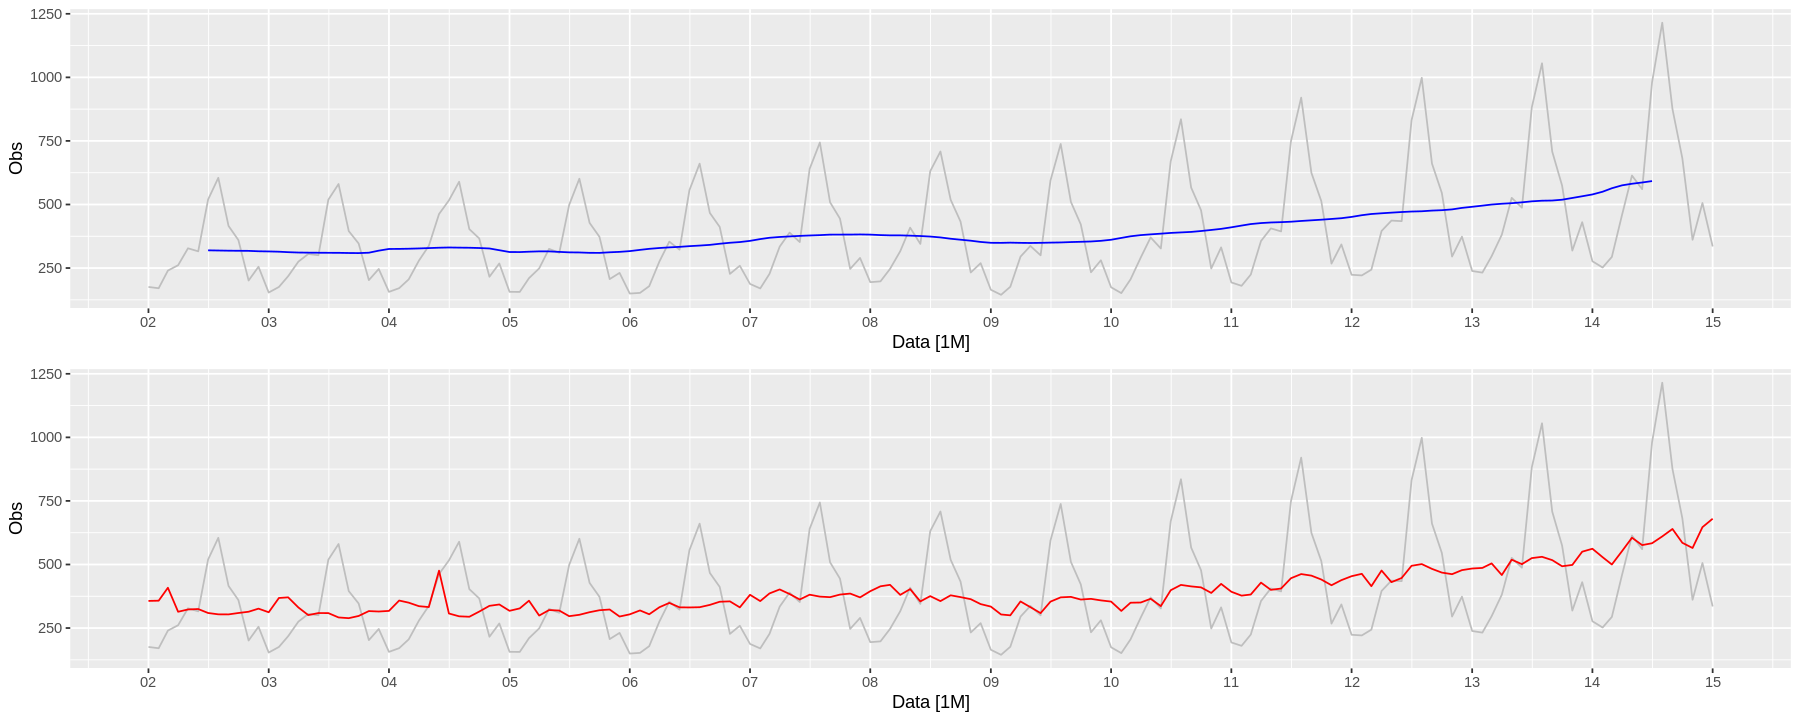

In [ ]:
serie_e_tend <- autoplot(ts1, Obs, color = 'gray') +
  autolayer(comp_ts1_DC_mult, trend, color = 'blue') +
  scale_x_yearmonth(date_breaks = '1 year', date_labels = '%y')

serie_e_semsaz <- autoplot(ts1, Obs, color = 'gray') +
  autolayer(comp_ts1_DC_mult, season_adjust, color = 'red') +
  scale_x_yearmonth(date_breaks = '1 year', date_labels = '%y')

gridExtra::grid.arrange(serie_e_tend, serie_e_semsaz, nrow=2)

In [ ]:
impacto <- outliers_DC$season_adjust - outliers_DC$trend

paste("Impacto económico estimado do Euro 2004:", #para fazer print com várias strings
      round(impacto, 2), #arredondar a duas casa decimais
      "milhões de euros")

[1] "Impacto económico estimado do Euro 2004: 145.71 milhões de euros"

# Outras decomposições para `ts1`

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


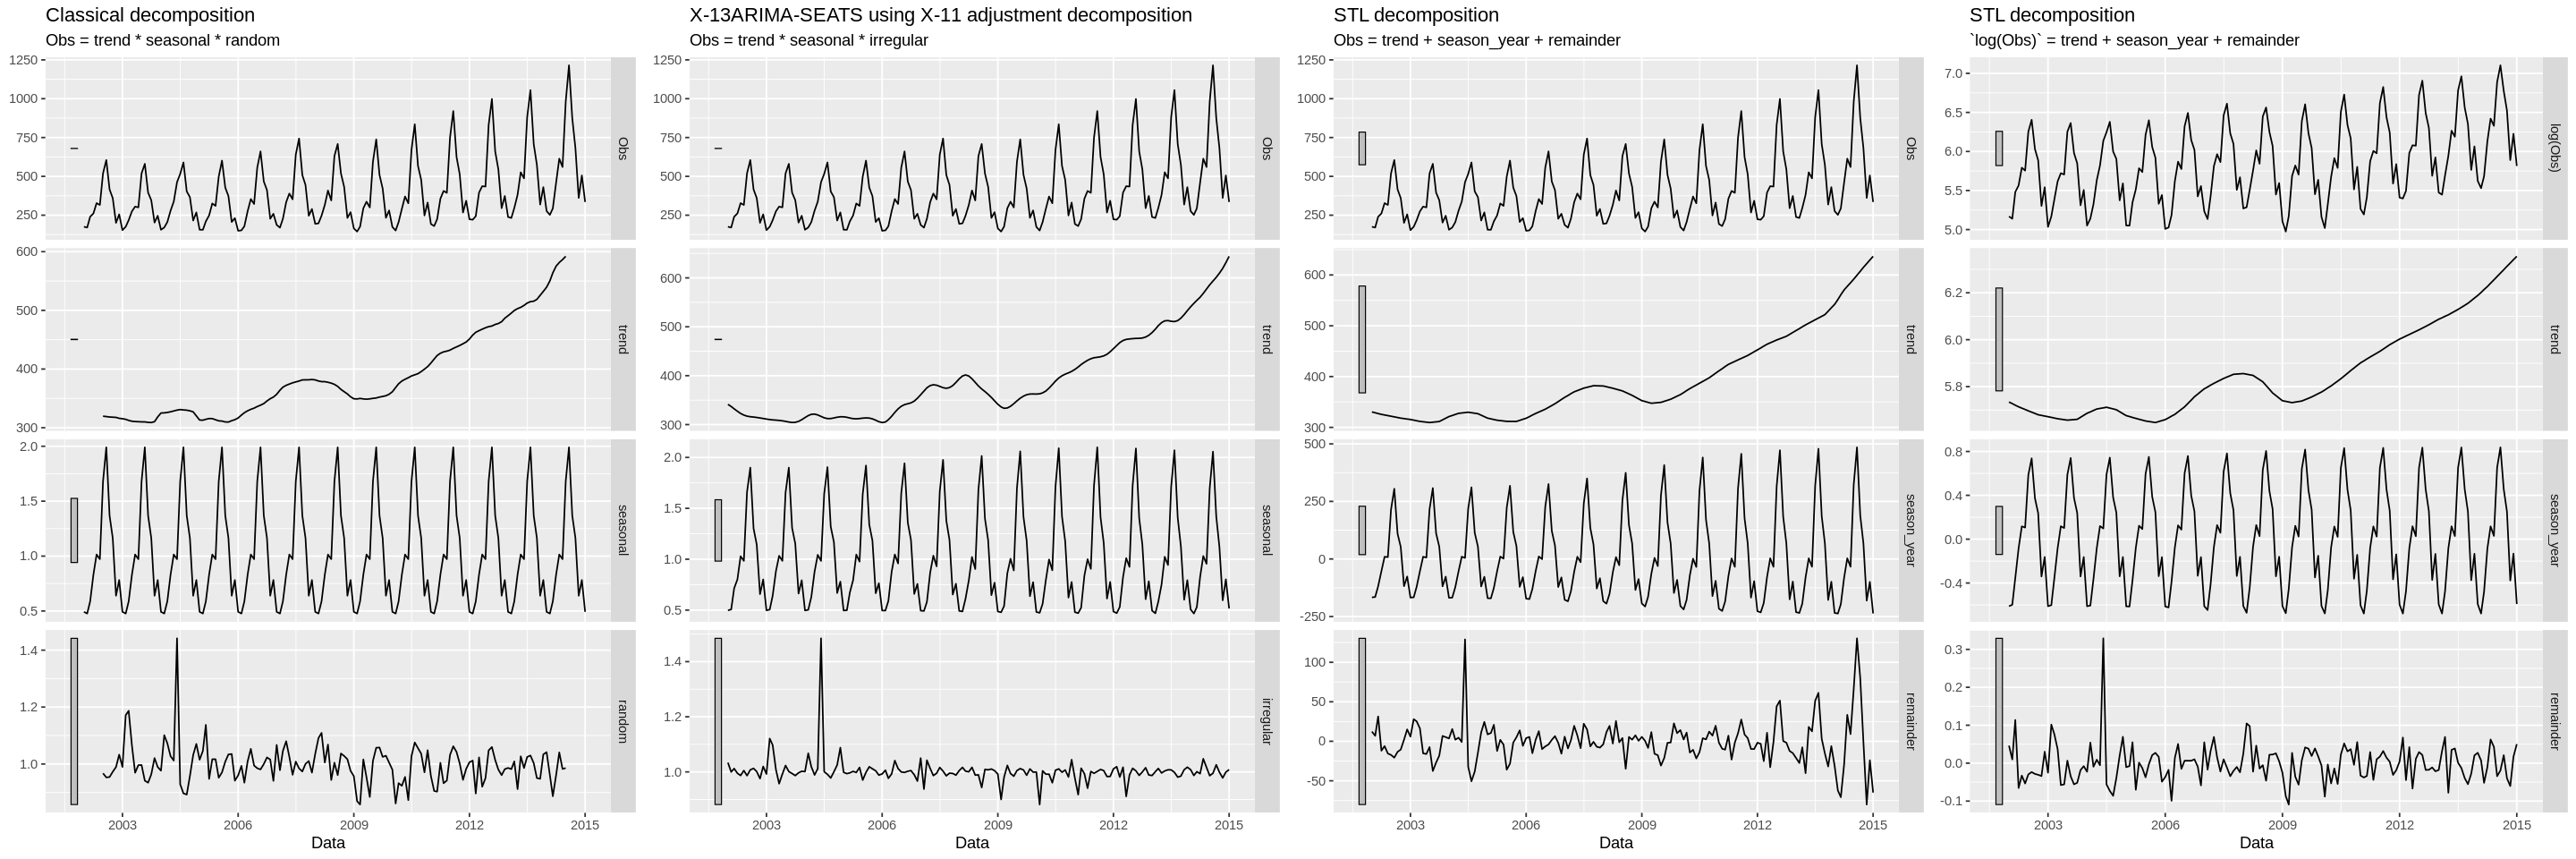

In [ ]:
# decomposição clássica multiplicativa
comp_ts1_DC_mult <- ts1 %>% 
    model(classical_decomposition(Obs, "multiplicative")) %>% 
    components()

# decomposição X11 multiplicativa
comp_ts1_Dx11_mult <- ts1 %>% 
    model(X_13ARIMA_SEATS(Obs ~ x11())) %>% 
    components()

# decomposição STL aditiva
comp_ts1_Dstl_adit <- ts1 %>% 
    model(STL(Obs)) %>% 
    components()

# decomposição STL multiplicativa
comp_ts1_Dstl_mult <- ts1 %>% 
    model(STL(log(Obs))) %>% 
    components()

# cronogramas
ts1_DC_mult_plot <- autoplot(comp_ts1_DC_mult) +
  scale_x_yearmonth(date_breaks = '3 years', date_labels = '%Y')

ts1_Dx11_mult_plot <- autoplot(comp_ts1_Dx11_mult) +
  scale_x_yearmonth(date_breaks = '3 years', date_labels = '%Y')

ts1_Dstl_adit_plot <- autoplot(comp_ts1_Dstl_adit) +
  scale_x_yearmonth(date_breaks = '3 years', date_labels = '%Y')

ts1_Dstl_mult_plot <- autoplot(comp_ts1_Dstl_mult) +
  scale_x_yearmonth(date_breaks = '3 years', date_labels = '%Y')

options(repr.plot.width=24, repr.plot.height=8)
gridExtra::grid.arrange(ts1_DC_mult_plot, ts1_Dx11_mult_plot, ts1_Dstl_adit_plot, ts1_Dstl_mult_plot, ncol=4)

In [ ]:
# componente irregular da decomposição x11 multiplicativa > designação 'irregular'
print(comp_ts1_Dx11_mult %>% select(Data, irregular))

# A tsibble: 157 x 2 [1M]
       Data irregular
      <mth>     <dbl>
 1 2002 Jan     1.03 
 2 2002 Feb     1.00 
 3 2002 Mar     1.01 
 4 2002 Apr     0.995
 5 2002 May     0.987
 6 2002 Jun     1.00 
 7 2002 Jul     0.986
 8 2002 Aug     1.01 
 9 2002 Sep     1.01 
10 2002 Oct     1.00 
# … with 147 more rows


In [ ]:
outliers_x11 <- comp_ts1_Dx11_mult %>% 
  filter(irregular < quantile(irregular, 0.25, na.rm = TRUE) - 3*IQR(irregular, na.rm = TRUE) | 
         irregular > quantile(irregular, 0.75, na.rm = TRUE) + 3*IQR(irregular, na.rm = TRUE))

print(outliers_x11)

# A dable: 8 x 7 [1M]
# Key:     .model [1]
# :        Obs = trend * seasonal * irregular
  .model                       Data   Obs trend seasonal irregular season_adjust
  <chr>                       <mth> <dbl> <dbl>    <dbl>     <dbl>         <dbl>
1 X_13ARIMA_SEATS(Obs ~ x… 2003 Feb  176.  310.    0.505     1.12           348.
2 X_13ARIMA_SEATS(Obs ~ x… 2003 Mar  218.  310.    0.641     1.10           340.
3 X_13ARIMA_SEATS(Obs ~ x… 2004 Jun  462.  317.    0.983     1.48           470.
4 X_13ARIMA_SEATS(Obs ~ x… 2004 Dec  268.  316.    0.780     1.09           344.
5 X_13ARIMA_SEATS(Obs ~ x… 2009 Feb  145.  336.    0.479     0.900          302.
6 X_13ARIMA_SEATS(Obs ~ x… 2010 Feb  151.  363.    0.473     0.882          320.
7 X_13ARIMA_SEATS(Obs ~ x… 2011 Feb  180.  418.    0.470     0.918          383.
8 X_13ARIMA_SEATS(Obs ~ x… 2012 May  437.  474.    1.01      0.911          432.


In [ ]:
season_adjust_Jun2004 <- comp_ts1_Dx11_mult %>% 
  filter(Data == yearmonth("2004-06")) %>% 
  pull(season_adjust)

trend_Jun2004 <- comp_ts1_Dx11_mult %>% 
  filter(Data == yearmonth("2004-06")) %>% 
  pull(trend)

impacto <- season_adjust_Jun2004 - trend_Jun2004

paste("Impacto económico estimado do Euro 2004:", 
      round(impacto, 2), 
      "milhões de euros")

[1] "Impacto económico estimado do Euro 2004: 153.48 milhões de euros"

# Componente de tendência para `ts2`

Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


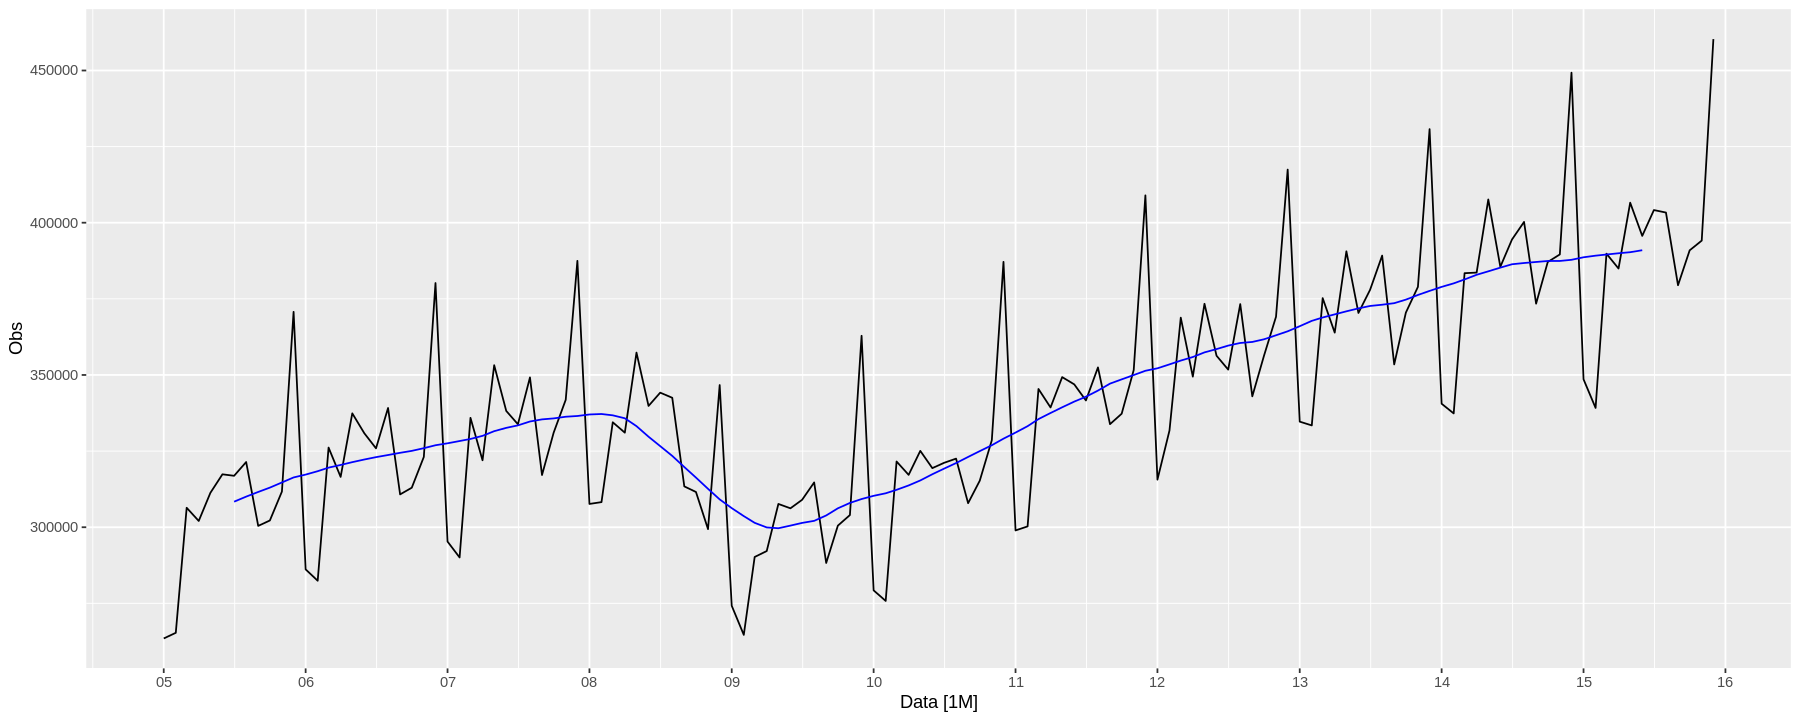

In [ ]:
comp_ts2_DC_adit <- ts2 %>% 
    model(classical_decomposition(Obs, 'additive')) %>% 
    components()

options(repr.plot.width=15, repr.plot.height=6)
autoplot(ts2, Obs, color = 'black') +
  autolayer(comp_ts2_DC_adit, trend, color = 'blue') +
  scale_x_yearmonth(date_breaks = '1 year', date_labels = '%y')

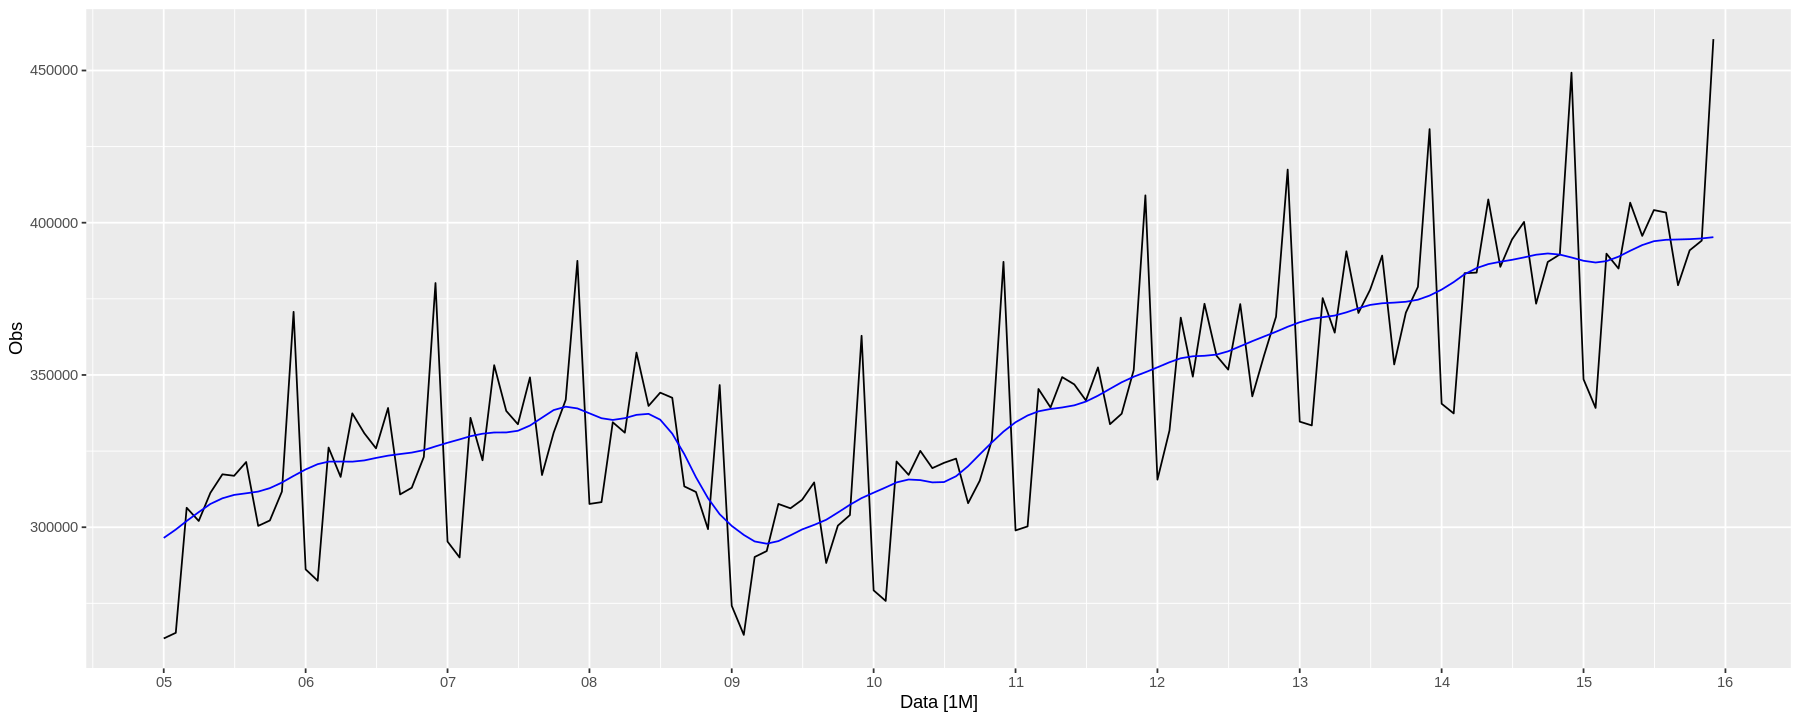

In [ ]:
comp_ts2_Dx11_mult <- ts2 %>%
    model(X_13ARIMA_SEATS(Obs~x11())) %>% 
    components()

autoplot(ts2, Obs, color = 'black') +
  autolayer(comp_ts2_Dx11_mult, trend, color = 'blue') +
  scale_x_yearmonth(date_breaks = '1 year', date_labels = '%y')

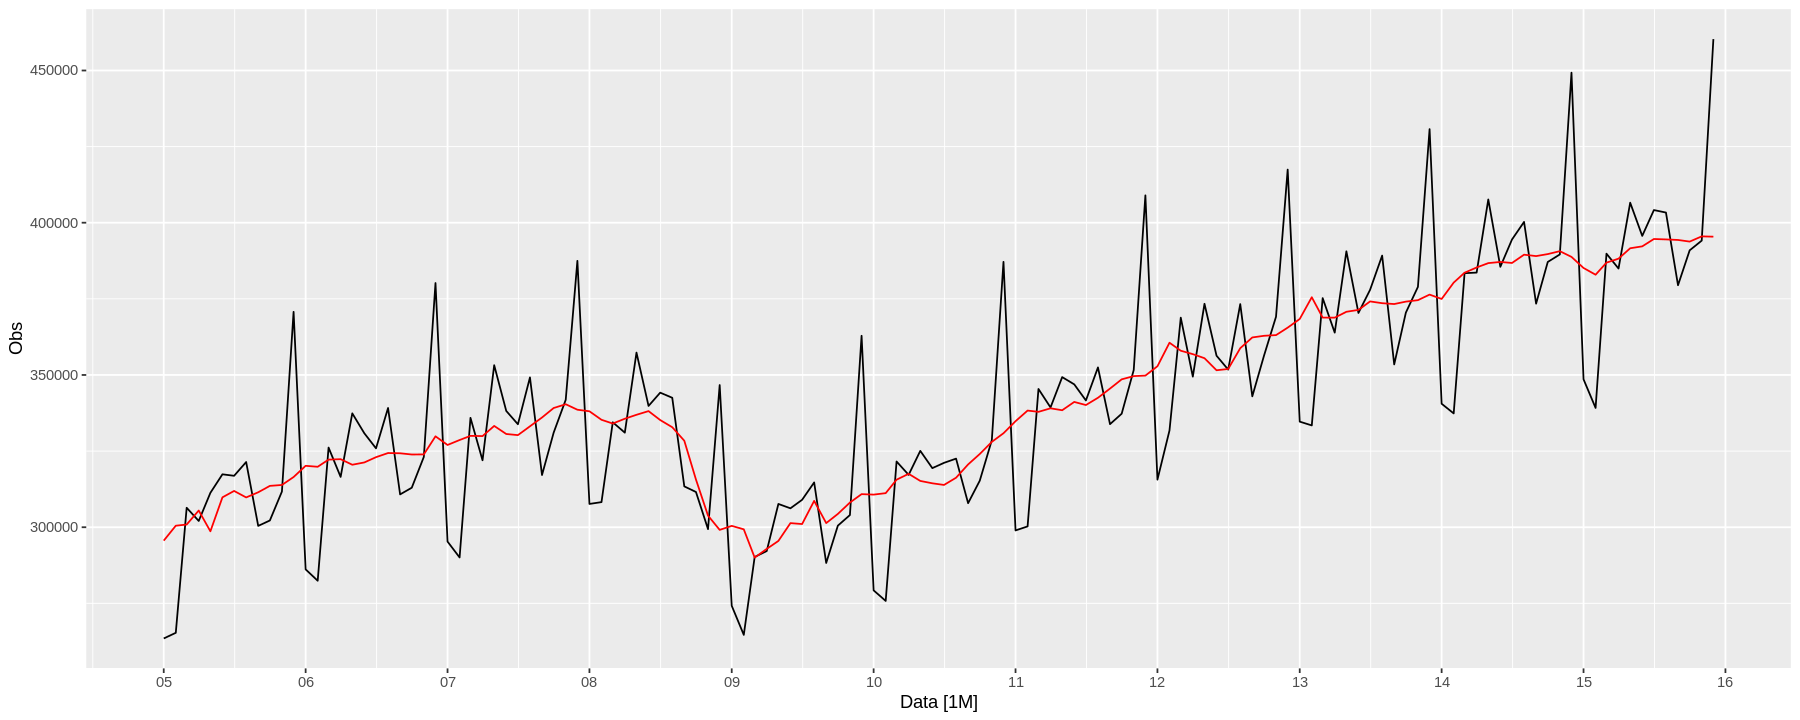

In [ ]:
autoplot(ts2, Obs, color = 'black') +
  autolayer(comp_ts2_Dx11_mult, season_adjust, color='red') +
  scale_x_yearmonth(date_breaks = '1 year', date_labels = '%y')

# *Features* da decomposição STL para `ts1` 

In [ ]:
ts1 %>% features(Obs, feat_stl)

trend_strength,seasonal_strength_year,seasonal_peak_year,seasonal_trough_year,spikiness,linearity,curvature,stl_e_acf1,stl_e_acf10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9081987,0.9795392,8,2,190.0989,948.9513,418.7952,0.4114489,0.6645936


# Exercício Extra

Considere a série seguinte:

```
tourism %>% filter(Region == "Adelaide Hills", Purpose == "Visiting")
```

**a.** Obtenha o cronograma desta série e indique as componentes de regularidade da série que estão presentes.

**b.** De acordo com a sua resposta à alínea anterior, obtenha a decomposição STL para esta série e comente-a.

**c.** Determine a força da tendência.

**d.** Houve algum trimestre excecional em termos do número de visitas (i.e. há outliers)? Em caso afirmativo, qual foi o impacto?

**e.** Substitua o(s) outlier(s) por um valor que considere adequado e recalcule a força da tendência.


In [ ]:
? tourism

In [ ]:
print(tourism)

In [ ]:
serie <- tourism %>% filter(Region == 'Adelaide Hills', Purpose == 'Visiting')

In [ ]:
serie %>% distinct(State) %>% pull()

## a.

In [ ]:
autoplot(serie, Trips) + geom_point() + 
  scale_x_yearquarter(date_breaks = '2 years', date_labels = 'Q%q-%y')

Apenas tendência, verificando-se um crescimento linear ligeiro. No entanto, a perceção relativamente à tendência está claramente a ser afetada pelo outlier que ocorre a Q4-2002.

## b.

In [ ]:
comp <- serie %>% 
    model(STL(Trips ~ season(period = 1))) %>% 
    components()

autoplot(comp)

Uma vez que a série não tem sazonalidade, essa componente não foi incorporada no modelo de decomposição, tendo tal sido conseguido fazendo o período de sazonalidade igual a 1.

A decomposição STL resultou bem, ficando evidente a tendência de crescimento razoavalmente linear. A componente irregular também é adequada (sem qualquer vestígio de regularidade), evidenciando o outlier severo detetado.

## c.

In [ ]:
features(serie, Trips, feat_stl)

Força da tendência: $F_T= 0.481$

## d.

In [ ]:
outlier <- comp %>% 
    filter(remainder < quantile(remainder, 0.25, na.rm = TRUE) - 3*IQR(remainder, na.rm = TRUE) | 
           remainder > quantile(remainder, 0.75, na.rm = TRUE) + 3*IQR(remainder, na.rm = TRUE))
outlier

In [ ]:
impacto <- outlier$season_adjust - outlier$trend
impacto

No 4.º trimestre de 2002, foram realizadas mais perto de 70 mil viagens, relativamente ao comportamento médio verificado.

## e.

Uma vez que o outlier verificado em 2002-Q4 é um valor superior a (3.º quartil + 3 x amplitude interquartil), admitindo que está correto e para não o desvirtuar por completo, vamos substituí-lo exatamente pelo valor da barreira que o levou a ser considerado um outlier.

In [ ]:
# antes da substituição
serie %>% filter(Quarter == yearquarter('2002 Q4'))

In [ ]:
# a substituição
serie_out <- serie
serie_out[20,5] <- comp$trend[20] + quantile(comp$remainder, 0.75, na.rm = TRUE) + 3*IQR(comp$remainder, na.rm = TRUE)

In [ ]:
# depois da substituição
serie_out %>% filter(Quarter == yearquarter('2002 Q4'))

In [ ]:
comp_out <- serie_out %>% model(STL(Trips ~ season(period = 1), robust = TRUE)) %>% components()
autoplot(comp_out)
features(serie_out, Trips, feat_stl)

Força da tendência: $F_T= 0.653$